In [1]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR 
import torchvision.transforms.functional as F

import cv2 as cv
import numpy as np
import time
import os
import logging
import sys
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from tqdm import tqdm

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join('/home/eccoope', 'pv-vision')
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join('/home/eccoope', 'el_img_cracks_ec', 'scripts')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

from tutorials.unet_model import construct_unet
import functions

In [ ]:
def load_dataset(root, load_val=False):
    transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])
    
    train_dataset = functions.SolarDataset(root, image_folder="img/train", 
            mask_folder="ann/train", transforms=transformers)
    
    test_dataset = functions.SolarDataset(root, image_folder="img/test", 
            mask_folder="ann/test", transforms=transformers)

    return train_dataset, test_dataset

In [ ]:
def load_device_and_model(weight_path):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    unet = construct_unet(5)
    unet = torch.nn.DataParallel(unet)
    
    checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))
    from collections import OrderedDict

    new_state_dict = OrderedDict()
    for k, v in checkpoint.items():
        name = "module." + k
        new_state_dict[name] = v

    unet.load_state_dict(new_state_dict)

    model = unet.module.to(device)
    
    return device, model

In [ ]:
def get_save_dir(base_dir, checkpoint_name="retrain_corners_checkpoint"):
    folders = [folder for folder in os.listdir(base_dir)]
    
    max_number = 0
    for folder in folders:
        number = folder[-1]
        if number > max_number:
            max_number = number

    new_folder_name = f"{checkpoint_name}{max_number + 1}"
    new_folder_path = os.path.join(base_dir, new_folder_name)
    
    os.makedirs(new_folder_path, exist_ok=True)
    
    return new_folder_path

In [ ]:
# root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/')
train_dataset, test_dataset = load_dataset(root)


weight_path = '/home/osanghi/pvcracks/retrained_pv-vision_model.pt'
device, model = load_device_and_model(weight_path)

In [ ]:
batch_size_test=1
batch_size_train=1
lr = 0.000001
step_size=1
gamma = 0.1
num_epochs = 30
criterion = torch.nn.SmoothL1Loss()

save_dir = get_save_dir(str(root))
os.makedirs(save_dir, exist_ok=True)

my_dict = {'batch_size_test' : batch_size_test,
           'batch_size_train' : batch_size_train,
           'lr' : lr,
           'step_size' : step_size,
           'gamma' : gamma,
           'num_epochs' : num_epochs,
           'criterion' : str(criterion)}

with open(os.path.join(save_dir, 'params.json'), 'w', encoding='utf-8') as f:
    json.dump(my_dict, f, ensure_ascii=False, indent=4)


train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

In [7]:
optimizer = Adam(model.parameters(), lr=lr)
lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
evaluate_metric=None
running_record = {'train': {'loss': []}, 'test': {'loss': []}}

save_name='model.pt'
cache_output = True

In [ ]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

In [ ]:
def inference_and_show(idx, retrained=False):
    img, mask = train_loader.dataset. __getitem__(idx)
    img = img.to(device)
    raw_img, _ = train_loader.dataset. __getraw__(idx)
    test_res = model(img.unsqueeze(0)).detach().cpu().numpy().squeeze()#.argmax(axis = 0)
    test_res = np.argmax(test_res, axis = 0)

    mask_cpu = mask.cpu().numpy()

    cmap = mpl.colormaps['viridis'].resampled(5)  # define the colormap
    cmaplist = [cmap(i) for i in range(5)]

    fig, ax = plt.subplots(ncols=3, figsize=(12,12))

    im = ax[0].imshow(raw_img.convert('L'), cmap='gray', interpolation='None')
    ax[0].axis('off')

    clim = (0, 4)
    im = ax[1].imshow(mask_cpu, cmap = 'viridis', clim=clim)
    ax[1].axis('off')
    ax[1].set_title("Ground Truth Mask")

    ax[2].imshow(test_res, cmap = 'viridis', clim = clim, interpolation='None')
    handles, labels = ax[2].get_legend_handles_labels()

    for c, classlabel in zip(cmaplist, [f'({k}) {v}' for k, v in category_mapping.items()]):
            patch = mpatches.Patch(color=c, label=classlabel, ec='k')
            handles.append(patch)
    ax[2].legend(handles=handles, fontsize='x-small')
    ax[2].axis('off')
    if retrained:
        ax[2].set_title("Retrained Model Prediction")
    else:
        ax[2].set_title("Model Prediction")

# Training

In [19]:
training_epoch_loss = []
test_epoch_loss = []

for epoch in tqdm(range(1, num_epochs + 1)):
    
    training_step_loss = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        output_activated = 1 /(1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes = 5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        
        training_loss = criterion(output_activated, target_onehot.float())
        training_loss.backward()
        optimizer.step()
        training_step_loss.append(training_loss.item())
        
    training_epoch_loss.append(np.array(training_step_loss).mean())
        
    test_step_loss = []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        data = data.to(device)
        
        output = model(data)
        output_activated = 1 /(1 + torch.exp(-output))
        target_onehot = torch.nn.functional.one_hot(target, num_classes = 5)
        target_onehot = torch.moveaxis(target_onehot, 3, 1)
        test_loss = criterion(output_activated, target_onehot.float())
        
        test_step_loss.append(test_loss.item())
        
    test_epoch_loss.append(np.array(test_step_loss).mean())
    
    os.makedirs(os.path.join(save_dir, f'epoch_{epoch}'), exist_ok=True)
    torch.save(model.state_dict(), os.path.join(save_dir, f'epoch_{epoch}', save_name))
    # logger.info(f'Saved model at epoch {epoch}')
    print(f'Saved model at epoch {epoch}')

100%|███████████████████████████████████████████████████████████████████████████████████| 30/30 [06:48<00:00, 13.60s/it]


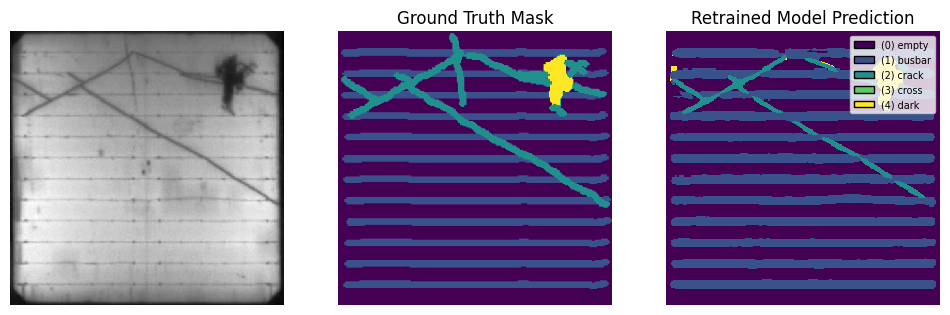

In [20]:
inference_and_show(-32, retrained=True)

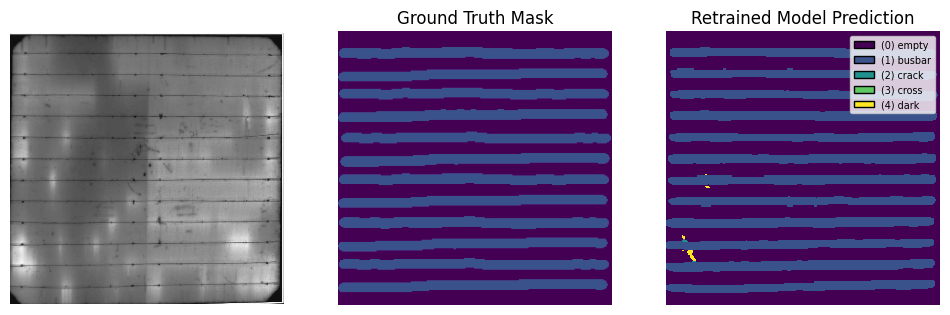

In [22]:
inference_and_show(13, retrained=True)

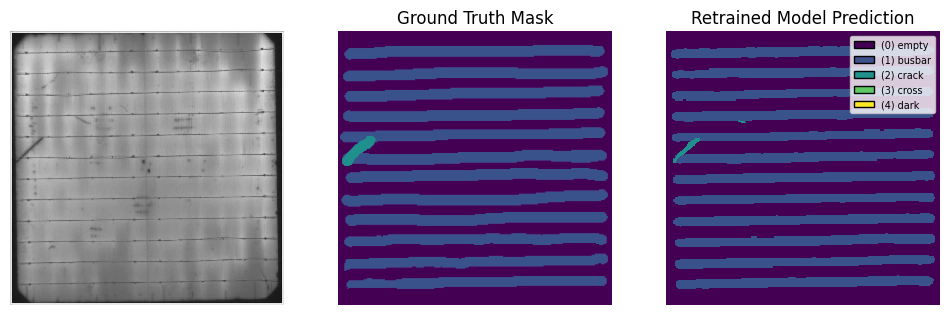

In [23]:
inference_and_show(44, retrained=True)

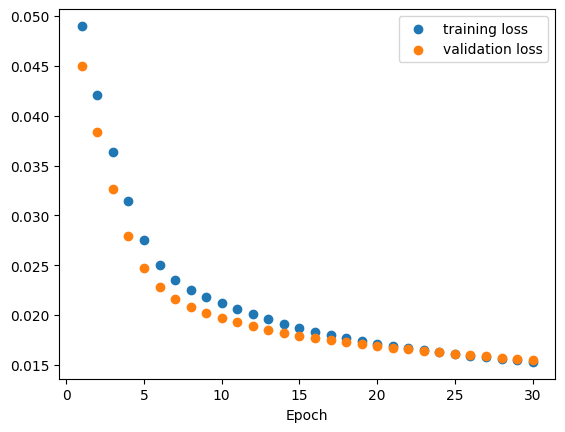

In [24]:
fig, ax = plt.subplots()

x = np.arange(1, len(training_epoch_loss) + 1, 1)

ax.scatter(x, training_epoch_loss, label='training loss')
ax.scatter(x, test_epoch_loss, label='testing loss')
ax.legend()
ax.set_xlabel('Epoch')